Set Up for the Agentic Rag

In [1]:
# conda create -n langchain
# conda activate langchain
# conda install ipykernel

In [2]:
# pip install -r requirements.txt

In [1]:
# Importamos librerías necesarias
import os
from dotenv import load_dotenv, find_dotenv

# Cargamos variables de entorno
dotenv_path = load_dotenv()

# Leemos las claves
token_gemini = os.getenv("GOOGLE_API_KEY")

# Verificar que las claves existen
if not token_gemini:
    raise ValueError("❌ Falta la clave GOOGLE_API_KEY en el archivo .env")

print("✅ Claves cargadas correctamente")

✅ Claves cargadas correctamente


## 1 Preprocess the Documents

### 1. Scrap Xataka Web Site

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from langchain_core.documents import Document
from time import sleep

from typing import List, Set

import requests
from bs4 import BeautifulSoup

# --------------------------------------
# 1. Leer el sitemap_index.xml
# --------------------------------------

def get_category_sitemaps(index_url="https://www.xataka.com/sitemap_index.xml"):
    headers = {"User-Agent": "Bot/1.0"}
    response = requests.get(index_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    sitemaps = [loc.get_text() for loc in soup.find_all("loc")]
    return sitemaps

category_sitemaps = get_category_sitemaps()
print(f"Se han encontrado {len(category_sitemaps)} sitemaps.")
print("Ejemplo:", category_sitemaps[:3])

# --------------------------------------
# 2. Filtrar solo las categorías importantes
# --------------------------------------

important_categories = [
    "moviles", "portatiles", "ordenadores", "componentes",
    "perifericos", "televisores", "software", "internet",
    "inteligencia-artificial", "videojuegos", "gadgets"
]

filtered_sitemaps = [
    url for url in category_sitemaps
    if any(f"/{cat}/" in url for cat in important_categories)
]

print(f"\nSe han filtrado {len(filtered_sitemaps)} sitemaps relevantes.")
print("Ejemplo:", filtered_sitemaps[:3])

# --------------------------------------
# 3. Extraer URLs de artículos desde los sitemaps
# --------------------------------------

def get_articles_from_category_sitemap(sitemap_url, max_articles=10):
    headers = {"User-Agent": "Bot/1.0"}
    response = requests.get(sitemap_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    urls = [loc.get_text() for loc in soup.find_all("loc")]
    return urls[:max_articles]

all_articles = []
seen_urls = set()

for sitemap_url in filtered_sitemaps:
    print(f"Procesando {sitemap_url}")
    articles = get_articles_from_category_sitemap(sitemap_url, max_articles=10)

    for url in articles:
        if url not in seen_urls:
            category = url.split("/")[3] if len(url.split("/")) > 3 else "desconocida"
            all_articles.append({
                "url": url,
                "category": category
            })
            seen_urls.add(url)
    sleep(0.5)  # ser amable con el servidor

print(f"\nTotal artículos únicos extraídos: {len(all_articles)}")
for a in all_articles[:3]:
    print(a)

# --------------------------------------
# 4. Scraping del contenido: title + text
# --------------------------------------

def scrape_article(url, category):
    headers = {"User-Agent": "Bot/1.0"}
    try:
        
        response = requests.get(url, headers=headers, timeout=10)
        response.encoding = 'utf-8' # <-- aquí el fix

        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        title_tag = soup.find("h1")
        paragraphs = soup.find_all("p")

        if not title_tag or not paragraphs:
            return None

        title = title_tag.get_text(strip=True)
        content = "\n\n".join([p.get_text(strip=True) for p in paragraphs])

        return {
            "url": url,
            "title": title,
            "content": content,
            "category": category
        }
    except Exception as e:
        print(f"❌ Error en {url}: {e}")
        return None

# Ejecutar scraping de todos los artículos
scraped_articles = []

for article in all_articles:
    result = scrape_article(article["url"], article["category"])
    if result:
        scraped_articles.append(result)

print(f"\nTotal artículos correctamente scrapeados: {len(scraped_articles)}")
for a in scraped_articles[:10]:
    print(f"- {a['title']} ({a['category']})")

Se han encontrado 335 sitemaps.
Ejemplo: ['https://www.xataka.com/categoria/default/sitemap.xml', 'https://www.xataka.com/categoria/otros/sitemap.xml', 'https://www.xataka.com/categoria/moviles/sitemap.xml']

Se han filtrado 7 sitemaps relevantes.
Ejemplo: ['https://www.xataka.com/categoria/moviles/sitemap.xml', 'https://www.xataka.com/categoria/ordenadores/sitemap.xml', 'https://www.xataka.com/categoria/videojuegos/sitemap.xml']
Procesando https://www.xataka.com/categoria/moviles/sitemap.xml
Procesando https://www.xataka.com/categoria/ordenadores/sitemap.xml
Procesando https://www.xataka.com/categoria/videojuegos/sitemap.xml
Procesando https://www.xataka.com/categoria/perifericos/sitemap.xml
Procesando https://www.xataka.com/categoria/televisores/sitemap.xml
Procesando https://www.xataka.com/categoria/componentes/sitemap.xml
Procesando https://www.xataka.com/categoria/inteligencia-artificial/sitemap.xml

Total artículos únicos extraídos: 64
{'url': 'https://www.xataka.com/moviles/nubi

### 2. Convertimos los documentos extraidos al formato Document que espera el Splitter

In [5]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content=article["content"],
        metadata={
            "title": article["title"],
            "url": article["url"],
            "category": article["category"]
        }
    )
    for article in scraped_articles
]

In [6]:
documents[0]

Document(metadata={'title': 'El sueño del móvil "todo pantalla" sigue vivo. Se llama Nubia Z80 Ultra y es una auténtica bestia', 'url': 'https://www.xataka.com/moviles/nubia-z80-ultra-caracteristicas-precio-ficha-tecnica', 'category': 'moviles'}, page_content='Amparo Babiloni\n\nAmparo Babiloni\n\nNubia no falla a su cita anual y acaba de anunciar su nuevo gama alta, el Nubia Z80 Ultra. La filial de ZTE sigue los pasos delNubia Z70 Ultray apuesta por una hoja técnica a la que prácticamente no le caben características más punteras. Además, este año se suben al carro delos móviles fotográficosconun kit que lo transforma en una cámara retro. Veamos todo lo que ofrece.Ficha técnica del Nubia Z80 Ultra\n\nNubia no falla a su cita anual y acaba de anunciar su nuevo gama alta, el Nubia Z80 Ultra. La filial de ZTE sigue los pasos delNubia Z70 Ultray apuesta por una hoja técnica a la que prácticamente no le caben características más punteras. Además, este año se suben al carro delos móviles fot

#### 2.1 Chunking

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from typing import List

def split_documents(
    docs: List[Document],
    chunk_size: int = 500,
    chunk_overlap: int = 100
) -> List[Document]:
    """
    Divide documentos largos en fragmentos más pequeños usando RecursiveCharacterTextSplitter.

    Args:
        docs: Lista de Documentos de LangChain.
        chunk_size: Tamaño máximo de cada fragmento.
        chunk_overlap: Número de caracteres que se solapan entre fragmentos.

    Returns:
        Lista de documentos divididos.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunked = text_splitter.split_documents(docs)
    print(f"📄 Documentos originales: {len(docs)} → 🧩 Chunks generados: {len(chunked)}")
    return chunked


In [8]:
doc_splits = split_documents(documents, chunk_size=500, chunk_overlap=200)

print(f"Se han generado {len(doc_splits)} fragmentos.")

📄 Documentos originales: 32 → 🧩 Chunks generados: 295
Se han generado 295 fragmentos.


In [9]:
doc_splits[0].page_content.strip()

'Amparo Babiloni\n\nAmparo Babiloni\n\nNubia no falla a su cita anual y acaba de anunciar su nuevo gama alta, el Nubia Z80 Ultra. La filial de ZTE sigue los pasos delNubia Z70 Ultray apuesta por una hoja técnica a la que prácticamente no le caben características más punteras. Además, este año se suben al carro delos móviles fotográficosconun kit que lo transforma en una cámara retro. Veamos todo lo que ofrece.Ficha técnica del Nubia Z80 Ultra\n\nNubia no falla a su cita anual y acaba de anunciar su nuevo gama alta, el Nubia Z80 Ultra. La filial de ZTE sigue los pasos delNubia Z70 Ultray apuesta por una hoja técnica a la que prácticamente no le caben características más punteras. Además, este año se suben al carro delos móviles fotográficosconun kit que lo transforma en una cámara retro. Veamos todo lo que ofrece.\n\n\n\nnubia z80 ultra\n\nDIMEnsiones y peso\n\n164,5 x 77,2 x 8,6 mm\n\n227 gramos\n\npantalla\n\nOLED de 6,85 pulgadas\n\nResolución FullHD+ (2.688 x 1.216 píxeles)\n\n144 H

In [10]:
doc_splits[1].page_content.strip()

'nubia z80 ultra\n\nDIMEnsiones y peso\n\n164,5 x 77,2 x 8,6 mm\n\n227 gramos\n\npantalla\n\nOLED de 6,85 pulgadas\n\nResolución FullHD+ (2.688 x 1.216 píxeles)\n\n144 Hz\n\n2.000 nits\n\nSin notch\n\nprocesador\n\nQualcomm Snapdragon 8 Elite Gen5\n\nmemoria ram\n\n12/16 GB LPDDR5x\n\nalmacenamiento interno\n\n256/512GB/1TB\n\nUFS 4.1\n\ncámaraS traseraS\n\nPrincipal: 50MP, 1/1.3", 35mm, OIS, f/1.7, OV50H\n\nUltra angular: 50MP, 1/1.55", 18mm, f/1.8, AF, Macro 5.5cm, OV50E\n\nTelefoto: 64MP, 70mm, f/2.48, OIS, OV64B\n\ncámara delantera\n\n16 MP\n\nbatería\n\n7.200 mAh\n\nCarga rápida 80W (con cable e inaámbrica)\n\nsistema operativo\n\nNebula AI OS 2.0\n\nAndroid 16\n\nconectividad\n\n5G, WiFi 7, Bluetooth 5.4, GPS L1+L2+L5, NFC\n\nUSB tipo C\n\notros\n\nCámara bajo la pantalla\n\nLector de huellas bajo la pantalla\n\nDesbloqueo facial\n\nDTS:X Ultra\n\nBotón de cámara\n\nInteligencia artificial\n\nResistencia al agua IP68, IP69\n\nprecio\n\nPor confirmar'

In [11]:
doc_splits[2].page_content.strip()

'cámara delantera\n\n16 MP\n\nbatería\n\n7.200 mAh\n\nCarga rápida 80W (con cable e inaámbrica)\n\nsistema operativo\n\nNebula AI OS 2.0\n\nAndroid 16\n\nconectividad\n\n5G, WiFi 7, Bluetooth 5.4, GPS L1+L2+L5, NFC\n\nUSB tipo C\n\notros\n\nCámara bajo la pantalla\n\nLector de huellas bajo la pantalla\n\nDesbloqueo facial\n\nDTS:X Ultra\n\nBotón de cámara\n\nInteligencia artificial\n\nResistencia al agua IP68, IP69\n\nprecio\n\nPor confirmar\n\nCorría el año 2020 cuando ZTE ocultó por primera vez la cámara frontal debajo de la pantalla delZTE Axon 20. Ya se ha convertido en una seña de identidad de sus gama alta y en su gama Nubia no iba a ser menos. Gracias a esto,el frontal del teléfono es todo pantalla,concretamente un panel de 6,85 pulgadas con brillo de hasta 2.000 nits y tasa de refresco de 144Hz. Además de la cámara frontal, la pantalla también esconde un lector de huellas.\n\nAl darle la vuelta nos encontramos con su otra seña de identidad, el módulo de cámara que recuerda al a

## 2. Creamos el retriever tool en memoria.

### 1. Use an in-memory vector store and Gemini embeddings

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004") # <-- USA ESTE MODELO, ES MÁS MODERNO
vectorstore = InMemoryVectorStore(embedding=embeddings)

In [13]:
# 2. Procesa por batches (lotes). Tenemos que procesar por lotes por que no admite mas de 300000  tokens
batch_size = 500

for i in range(0, len(doc_splits), batch_size):
    batch = doc_splits[i:i + batch_size]
    # Procesa cada batch aquí. Ejemplo: añade al VectorStore
    vectorstore.add_documents(batch)
    print(f"Procesando batch {i//batch_size + 1} con {len(batch)} chunks...")

Procesando batch 1 con 295 chunks...


In [14]:
retriever = vectorstore.as_retriever()

### 2. Creamos una retriever **tool** usando LangChain's prebuilt create_retriever_tool:

In [18]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",#nombre
    "Busca y devuelve info acerca de articulos de Xakata.",#Descripcion
)

In [19]:
retriever_tool.invoke({"query": "Lanzamiento del El Honor Magic V5"})

'En Xataka |Los móviles con mejores cámaras que hemos analizado en los últimos meses\n\nLos mejores comentarios:\n\nVer6 comentarios\n\nEn Xataka hablamos de...\n\nVer más temas\n\nWebedia\n\nTecnología\n\nVideojuegos\n\nEntretenimiento\n\nGastronomía\n\nMotor\n\nEstilo de vida\n\nEconomía\n\nEdiciones Internacionales\n\nPartners\n\nDestacamos\n\nVer más temas\n\nSuscribir\n\nMás sitios que te gustarán\n\nReciente\n\nVer más artículos\n\nXatakaTV\n\nVer más vídeos\n\nImágenes | Xiaomi\n\nEn Xataka |Tras los móviles, los coches, los robots y la IA, llega la próxima gran avalancha tecnológica de China: las gafas\n\n\n\nLos mejores comentarios:\n\nVer4 comentarios\n\nEn Xataka hablamos de...\n\nVer más temas\n\nWebedia\n\nTecnología\n\nVideojuegos\n\nEntretenimiento\n\nGastronomía\n\nMotor\n\nEstilo de vida\n\nEconomía\n\nEdiciones Internacionales\n\nPartners\n\nDestacamos\n\nVer más temas\n\nSuscribir\n\nMás sitios que te gustarán\n\nReciente\n\nVer más artículos\n\nXatakaTV\n\nVer más v

### 3. Test the tool

## 3. Generamos la Query.
Ahora comenzaremos a construir los componentes (nodos y aristas) para nuestro grafo agentic RAG. Ten en cuenta que los componentes operarán sobre el MessagesState — el estado del grafo que contiene una clave messages con una lista de mensajes de chat.

### 1.Construir un **nodo genera_query_o_responde**. Este llamará a un LLM para generar una respuesta basada en el estado actual del grafo (lista de mensajes). Dado el conjunto de mensajes de entrada, decidirá si recuperar información usando la herramienta de recuperación (retriever tool), o responder directamente al usuario. Ten en cuenta que le estamos dando acceso al modelo conversacional a la herramienta de recuperación que creamos antes, a través de .bind_tools:

In [20]:
from langgraph.graph import MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI

# response_model=  ChatOpenAI(model="gpt-4o", temperature=0) # <-- ELIMINAR ESTA LÍNEA

response_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

def genera_query_o_responde(state: MessagesState):
    """Llama al modelo para generar una respuesta basada en el estado actual.
      Dada la pregunta, decidirá si recupera información usando la herramienta de recuperación o simplemente responde al usuario."""
    response = (
        response_model
        .bind_tools(tools=[retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}



### 2. Lo probamos con una pregunta aleatoria que no tenga que ver con la info obtenida

In [21]:
input = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
respuesta= genera_query_o_responde(input)
print (respuesta)

{'messages': [AIMessage(content=[{'type': 'text', 'text': 'Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka.', 'extras': {'signature': 'Cr0OAdHtim/QREPvCmBRfehkLMlpUoi0F7gKg8osIHSh/jNdQRgCNK5raDDt8BYdlUPevmqF5z/cm0rG548oXaXJFhaPnJSqyEf728YCV77gtSZCoJK2E9vUbvdobTMmlEgA9XW0PtxQqrMeGtFXPgDXb+HZDWKY5NIScvbqxR2X6K77mlulLEAxtIGxl3glkScWIBRxAa6F0gRC3k+xaYXsSQJdCglDBTjElSXb0xObiFxhv6mCFr5+SXTIUjnupA86yq+NvRIBaWjZ5t18/gWlfhP9fVEd24refEdQ0sexKJEFjw5gzxbf0irtfaFjd1c3rhO0JA5dZ9SzTUy4xJQSC5hm3lIIC0OhShKuncv1/CaZYEn8RvJmtn7LC0c1sQdIIXeoLN60UZClu6ei/1nFovfpsGXcULvrbb2v8rXFvpTl3hCbiIggoEUARooyRop9fiYzYW8VgzV6Fs+0SMTHQMxK8bUV6L1XDZX327+lezwROx8vM83YlU7rcLH7JglLiZPZS2m764hSWhiuDEvrIF6RrTIrr1GCZtD9zRM3YQ770lwV0gsOTWcbk8/TOrHt3zLHXmwKHtH/VrZKhrZrzTso/bzFWyAjRCgOEf1nqb2gZLQxxN5bvakV9ylgrAw+WQr7+I3FSMqLqo8i/jX5ffEOtLO9TN+6Sb5KzdRB3xLYMa8mPITM05JzVmYUWwkE+92mSeO2JDT90dbc3k4QieQ7W3VxbyqJqmnPFqB+yBFgMWIW+quqHbwIGMBH8n2+rZG+cWAvEGYdt3ktwmjrHu+EKIRz1oJBh

In [22]:
#cogemos el ultimo mensaje
respuesta["messages"][-1]

AIMessage(content=[{'type': 'text', 'text': 'Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka.', 'extras': {'signature': 'Cr0OAdHtim/QREPvCmBRfehkLMlpUoi0F7gKg8osIHSh/jNdQRgCNK5raDDt8BYdlUPevmqF5z/cm0rG548oXaXJFhaPnJSqyEf728YCV77gtSZCoJK2E9vUbvdobTMmlEgA9XW0PtxQqrMeGtFXPgDXb+HZDWKY5NIScvbqxR2X6K77mlulLEAxtIGxl3glkScWIBRxAa6F0gRC3k+xaYXsSQJdCglDBTjElSXb0xObiFxhv6mCFr5+SXTIUjnupA86yq+NvRIBaWjZ5t18/gWlfhP9fVEd24refEdQ0sexKJEFjw5gzxbf0irtfaFjd1c3rhO0JA5dZ9SzTUy4xJQSC5hm3lIIC0OhShKuncv1/CaZYEn8RvJmtn7LC0c1sQdIIXeoLN60UZClu6ei/1nFovfpsGXcULvrbb2v8rXFvpTl3hCbiIggoEUARooyRop9fiYzYW8VgzV6Fs+0SMTHQMxK8bUV6L1XDZX327+lezwROx8vM83YlU7rcLH7JglLiZPZS2m764hSWhiuDEvrIF6RrTIrr1GCZtD9zRM3YQ770lwV0gsOTWcbk8/TOrHt3zLHXmwKHtH/VrZKhrZrzTso/bzFWyAjRCgOEf1nqb2gZLQxxN5bvakV9ylgrAw+WQr7+I3FSMqLqo8i/jX5ffEOtLO9TN+6Sb5KzdRB3xLYMa8mPITM05JzVmYUWwkE+92mSeO2JDT90dbc3k4QieQ7W3VxbyqJqmnPFqB+yBFgMWIW+quqHbwIGMBH8n2+rZG+cWAvEGYdt3ktwmjrHu+EKIRz1oJBhCz5LHrT/TWCDmp

In [23]:
#Formateamos el mensaje
respuesta["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': 'Lo siento, no puedo darte el precio de una cortina. Mi función es buscar información en artículos de Xataka.', 'extras': {'signature': 'Cr0OAdHtim/QREPvCmBRfehkLMlpUoi0F7gKg8osIHSh/jNdQRgCNK5raDDt8BYdlUPevmqF5z/cm0rG548oXaXJFhaPnJSqyEf728YCV77gtSZCoJK2E9vUbvdobTMmlEgA9XW0PtxQqrMeGtFXPgDXb+HZDWKY5NIScvbqxR2X6K77mlulLEAxtIGxl3glkScWIBRxAa6F0gRC3k+xaYXsSQJdCglDBTjElSXb0xObiFxhv6mCFr5+SXTIUjnupA86yq+NvRIBaWjZ5t18/gWlfhP9fVEd24refEdQ0sexKJEFjw5gzxbf0irtfaFjd1c3rhO0JA5dZ9SzTUy4xJQSC5hm3lIIC0OhShKuncv1/CaZYEn8RvJmtn7LC0c1sQdIIXeoLN60UZClu6ei/1nFovfpsGXcULvrbb2v8rXFvpTl3hCbiIggoEUARooyRop9fiYzYW8VgzV6Fs+0SMTHQMxK8bUV6L1XDZX327+lezwROx8vM83YlU7rcLH7JglLiZPZS2m764hSWhiuDEvrIF6RrTIrr1GCZtD9zRM3YQ770lwV0gsOTWcbk8/TOrHt3zLHXmwKHtH/VrZKhrZrzTso/bzFWyAjRCgOEf1nqb2gZLQxxN5bvakV9ylgrAw+WQr7+I3FSMqLqo8i/jX5ffEOtLO9TN+6Sb5KzdRB3xLYMa8mPITM05JzVmYUWwkE+92mSeO2JDT90dbc3k4QieQ7W3VxbyqJqmnPFqB+yBFgMWI

### 3. Hacer una pregunta que requiera búsqueda semántica

In [40]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Lanzamiento del Nubia Z80 Ultra",
        }
    ]
}
genera_query_o_responde(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (02ddb339-632d-4ddb-8125-7641d9b36fe5)
 Call ID: 02ddb339-632d-4ddb-8125-7641d9b36fe5
  Args:
    query: Lanzamiento del Nubia Z80 Ultra


## 4. Vemos la relevanciade los documentos

###  1.  Añade una arista condicional —grade_documents— para determinar si los documentos recuperados son relevantes para la pregunta. <span style="color:red">Utilizaremos un modelo con un esquema de salida estructurado llamado GradeDocuments</span> para la calificación de documentos. La función grade_documents devolverá el nombre del nodo al que se debe ir según la decisión de calificación (genera respuesta o reescribe_pregunta):

Conceptos a recordar: 
* <span style="color:red">arista condicional</span>

In [25]:
from pydantic import BaseModel, Field
from typing import Literal
# Importamos la clase del modelo de chat de Gemini
from langchain_google_genai import ChatGoogleGenerativeAI


GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \\n "
    "Aquí tienes el documento recuperado: \\n\\n {context} \\n\\n"
    "Aquí tienes la pregunta del usuario: {question} \\n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \\n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."

)


class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""

    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )
# AHORA (LA FORMA CORRECTA):
grader_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["genera_respuesta", "rescribir_question"]:
    """Determina si los documentos recuperados son relevantes para la pregunta."""
    question = state["messages"][0].content
    # El último mensaje es la salida de la herramienta (tool)
    context = state["messages"][-1].content
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print ("score :", score)
    if score == "si":
        return "genera_respuesta"
    else:
        return "rescribir_question"

### 2. Ejecutar con una respuesta irrelevante en la respuesta de la tool :

In [41]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que tiempo hace en Alicante?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Tiempo en Alicante"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

print ("input:" , input)
grade_documents(input)

input: {'messages': [HumanMessage(content='¿Que tiempo hace en Alicante?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Tiempo en Alicante'}, 'id': '1', 'type': 'tool_call'}]), ToolMessage(content='Son las 10 de la mañana', tool_call_id='1')]}
score : no


'rescribir_question'

### 3. Confirmar que el documento/respuesta relavante se  clasifica como tal:

In [42]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

score : si


'genera_respuesta'

## 5 Rescribir la pregunta.

### 1. Construye el nodo de reescritura de pregunta (rescribir_question).
La herramienta de recuperación puede devolver documentos potencialmente irrelevantes, lo que indica la necesidad de mejorar la pregunta original del usuario. Para ello, llamaremos al nodo rewrite_question.

In [ ]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)


def rescribir_question(state: MessagesState):
    """Rescribe/Mejora la pregunta original del usuario."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    print ("Prompt",prompt)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

#### 2. Try it out:

In [43]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Dame informacion sobre el Nubia Z80 Ultra",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Dame informacion sobre el Nubia Z80 Ultra"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])

xavi Prompt Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.
Pregunta original:
 ------- 
Dame informacion sobre el Nubia Z80 Ultra
 ------- 
Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:
La intención profunda de la pregunta es obtener un panorama completo y relevante sobre un dispositivo móvil específico, asumiendo su existencia. El usuario no solo quiere "información" genérica, sino detalles que le permitan entender qué es el Nubia Z80 Ultra, qué ofrece y cuál es su estado actual en el mercado o en el ciclo de noticias tecnológicas. También hay una intención implícita de verificar si dicho modelo existe o es un rumor.

Aquí tienes la pregunta reescrita para ser más clara, precisa y fácil de entender:

**Pregunta reescrita:**

"Me gustaría obtener información detallada sobre el dispositivo móvil Nubia Z80 Ultra. ¿Podrías proporcionarme sus características principales, especificaci

## 6. Generamos la Respuesta.

### 1. Construimos el nodo generate_answer.
Si superamos las comprobaciones del evaluador (grader), podemos generar la respuesta final basándonos en la pregunta original y el contexto recuperado

In [45]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)



def genera_respuesta(state: MessagesState):
    """Genera la respuesta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 2. Try it out.

In [46]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "Dame informacion sobre Honor Magic V5",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Dame informacion sobre Honor Magic V5"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Honor Magic V5, un smartphone que apuesta por este singular formato pero lo hace con un componente cada vez más relevante: la IA.\n\nAsí, Google Gemini se convierte en parte fundamental de la experiencia de uso de un terminal que viene repleto de buenas especificaciones para convencernos de algo que debería ser obvio: dos pantallas son mejor que una.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

El Honor Magic V5 es un smartphone que destaca por su formato singular y la integración de IA, con Google Gemini como parte fundamental de su experiencia de usuario. Cuenta con buenas especificaciones y apuesta por la ventaja de tener dos pantallas.


## 7. Configurar el grafo

### 7.1 Importamos los elementos necesarios para construir el grafo

In [32]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### 7.2 Ensamblamos el workflow

#### 7.2.1 Añadimos los nodos

In [33]:
workflow = StateGraph(MessagesState)
workflow.add_node(genera_query_o_responde)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rescribir_question)
workflow.add_node(genera_respuesta)

#### 7.2.2 Añadimos las aristas

In [34]:
workflow.add_edge(START, "genera_query_o_responde")
workflow.add_conditional_edges(
    "genera_query_o_responde",
    # Evalúa la decisión del LLM (llama a la herramienta retriever_tool o responde al usuario)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

#
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("genera_respuesta", END)

workflow.add_edge("rescribir_question", "genera_query_o_responde")

#### 7.2.3 Compilamos el grafo

In [35]:
graph = workflow.compile()

#### 7.2.4 Pintamos el Grafo

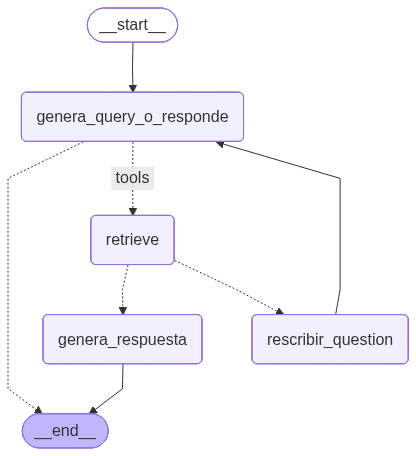

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### NOtas

In [47]:
from pprint import pprint  # para imprimir bonito
import pdb

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Dame informacion sobre el Nubia Z80 Ultra",
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"📘 Update from node: {node}")
        print("-" * 40)

        messages = update.get("messages", [])
      
        last_msg = messages[-1]

        try:
            if isinstance(last_msg, dict):
                if "content" in last_msg:
                    print("📝 Contenido textual:")
                    print(last_msg["content"])
                elif "tool_calls" in last_msg:
                    print("🔧 Llamada a función:")
                    pprint(last_msg["tool_calls"])
                else:
                    print("🕵️ Mensaje dict sin content/tool_calls:")
                    pprint(last_msg)
            elif hasattr(last_msg, "content"):
                print("📝 Contenido desde objeto:")
                print(last_msg.content)
            else:
                print("🕵️ Mensaje desconocido:")
                pprint(last_msg)

        except Exception as e:
            print("❌ Error leyendo el mensaje:", str(e))
            pprint(last_msg)

        print("-" * 40 + "\n")



📘 Update from node: genera_query_o_responde
----------------------------------------
📝 Contenido desde objeto:

----------------------------------------

score : si
📘 Update from node: retrieve
----------------------------------------
📝 Contenido desde objeto:
nubia z80 ultra

DIMEnsiones y peso

164,5 x 77,2 x 8,6 mm

227 gramos

pantalla

OLED de 6,85 pulgadas

Resolución FullHD+ (2.688 x 1.216 píxeles)

144 Hz

2.000 nits

Sin notch

procesador

Qualcomm Snapdragon 8 Elite Gen5

memoria ram

12/16 GB LPDDR5x

almacenamiento interno

256/512GB/1TB

UFS 4.1

cámaraS traseraS

Principal: 50MP, 1/1.3", 35mm, OIS, f/1.7, OV50H

Ultra angular: 50MP, 1/1.55", 18mm, f/1.8, AF, Macro 5.5cm, OV50E

Telefoto: 64MP, 70mm, f/2.48, OIS, OV64B

cámara delantera

16 MP

batería

7.200 mAh

Carga rápida 80W (con cable e inaámbrica)

sistema operativo

Nebula AI OS 2.0

Android 16

conectividad

5G, WiFi 7, Bluetooth 5.4, GPS L1+L2+L5, NFC

USB tipo C

otros

Cámara bajo la pantalla

Lector de huella

In [48]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Dame la informacion mas relevanten y resumida sobre el Nubia Z80 Ultra",
        }
    ]
}

In [49]:
graph.invoke(input)["messages"][-1].pretty_print()

score : si
================================== Ai Message ==================================

El Nubia Z80 Ultra es un nuevo gama alta que integra el procesador Qualcomm Snapdragon 8 Elite Gen5, 12/16 GB de RAM y hasta 1TB de almacenamiento. Destaca por su pantalla OLED de 6.85 pulgadas a 144 Hz sin notch, un avanzado sistema de triple cámara trasera (50MP principal, 50MP ultra-angular, 64MP teleobjetivo) y una batería de 7.200 mAh con carga rápida de 80W. Funciona con Nebula AI OS 2.0 (Android 16) y ofrece resistencia IP68/IP69, además de un kit fotográfico opcional que lo convierte en una cámara retro.
